## 1. Set up communication with the FR3

### 1.1 Set up communication with the arm

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
# Print the arm state
robot.getJointStates()

{'q': array([-1.70972186e-04, -7.84550686e-01,  5.25229632e-04, -2.35657899e+00,
        -7.24342360e-04,  1.57096910e+00,  7.85007230e-01]),
 'dq': array([-9.48277862e-04, -5.07659938e-05,  7.88487838e-05, -7.52050325e-04,
         9.04569725e-04, -7.74325055e-04,  8.52681346e-04]),
 'T': array([ 0.11434627, -4.37341452, -1.05330503, 23.09573746,  1.16655195,
         2.14780402,  0.15337589]),
 'M': array([[ 4.83860364e-01, -1.01389985e-02,  4.81520542e-01,
         -1.21913407e-02,  5.55061788e-02, -3.83507973e-03,
          1.56978625e-03],
        [-1.01389985e-02,  1.53762368e+00,  5.03148141e-03,
         -6.90687174e-01, -1.43429566e-02, -2.38268465e-02,
         -6.82371193e-04],
        [ 4.81520542e-01,  5.03148141e-03,  9.84997073e-01,
         -2.77051169e-02,  6.82216594e-02, -4.61446721e-03,
          3.48890716e-03],
        [-1.21913407e-02, -6.90687174e-01, -2.77051169e-02,
          9.51028724e-01,  2.77295604e-02,  1.06065381e-01,
          3.14882640e-04],
        

# 2. Go to initial joint angle

In [3]:
import numpy as np
import time

In [4]:
## Some global parameters
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
joint_vel_lb = -np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61])
joint_vel_ub = np.array([2.175, 2.175, 2.175, 2.175, 2.61, 2.61, 2.61])

In [13]:
T = 7
q_init = np.array([ 0.8004, -0.9493, -1.0221, -2.1716, -0.309, 3.1311, 0.27])

Kp_joint = np.diag([1, 1, 1, 1, 4, 2, 1])*5
t_start = time.time()
while time.time() - t_start < T:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_init)
    dq = - Kp_joint @ eq
    dq = np.clip(dq, joint_vel_lb, joint_vel_ub)
    robot.setCommands(dq)

robot.setCommands(np.zeros_like(dq))

# 3. uaibot

In [6]:
import uaibot as ub

def create_cone(htm, radius, height):
#Create a cone-like object using Uaibot's capabilities of creating convex polytopes 
#defined by Ap<=b. 'htm' is the homogeneous transformation matrix representing the pose of the cylinder.
#'radius' is the radius of the base of the cone, and 'height' the height of the cone

    #Create the side inequalities Ap<=b for the cone
    no_sides = 6
    A = np.matrix(np.zeros((0,3)))
    b = np.matrix(np.zeros((0,1)))


    phi = np.arcsin(radius/np.sqrt(height**2+radius**2))

    for i in range(no_sides):
        theta = 2*np.pi*i/no_sides
        a = np.matrix([np.cos(phi)*np.cos(theta), np.cos(phi)*np.sin(theta), np.sin(phi)])
        A = np.vstack((A,a))
        b = np.vstack((b,radius))
        
    ##Add an inequality in the bottom (to cover the cone from the bottom)
    A = np.vstack((A,np.matrix([0,0,-1])))
    b = np.vstack((b,0))
    
    #Create the convex polytope
    cone = ub.ConvexPolytope(A=A,b=b,htm=ub.Utils.trn([0,0,0]),color='yellow')
    
    #Set the desired htm at time t=0
    cone.add_ani_frame(time=0,htm=htm)
    
    return cone
   
 
def funF(r):
#Function that is used in the control loop

    f = np.matrix(r)
    for j in range(np.shape(r)[0]):
        f[j,0] = np.sign(r[j,0])*np.sqrt(np.abs(r[j,0]))
        
    return f

In [7]:
##############################################################################
#Create list of obstacles
cone = create_cone(ub.Utils.trn([0.44,0,0.44]),radius=0.11,height=0.45)
table_top = ub.Box(ub.Utils.trn([0.4,0,0.22]),width=0.32,depth=0.48,height=0.44, color='magenta')
obstacles = [cone, table_top]

##############################################################################
#Create the robot
uai_robot = ub.Robot.create_franka_emika_3()
no_joint = np.shape(uai_robot.q)[0]

##############################################################################
#Create the initial pose and target pose
htm_init = ub.Utils.trn([0.45, -0.3, 0.7])*ub.Utils.roty(-np.pi/2)*ub.Utils.rotx(np.pi)
htm_des = ub.Utils.trn([0.45, 0.16, 0.7])*ub.Utils.roty(np.pi/2)*ub.Utils.rotx(np.pi/6)*ub.Utils.rotz(np.pi/2)

In [14]:
#Main control loop
#Parameters
dt = 0.01
#CBF eta
eta = 0.8
#Convergence gain
kconv = 0.5
#Smoothing parameter eps for obstacle avoidance
eps_to_obs = 0.003
#Smoothing parameter h for obstacle avoidance
h_to_obs = 0.003
#Smoothing parameter eps for auto collision avoidance
eps_auto = 0.02
#Smoothing parameter h for auto collision avoidance
h_auto = 0.05
#Safety margin obstacle avoidance
d_safe_obs = 0.016
#Safety margin auto collision avoidance
d_safe_auto = 0.002
#Safety margin joint
d_safe_jl = (np.pi/180)*1
#Error tolerance position (in mm)
tolp=1.0 
#Error tolerance angle (in def)
tolo=1.0 
#Regularization term for the controller
eps_reg = 0.01

In [15]:
timestamps_list = [] 
joint_angles_list = []
time_per_loop_list = []

T = 13
start_time = time.time()
while (time.time() - start_time < T):
    loop_start = time.time()
    robot_info = robot.getJointStates()
    #Get current configuration, in the real robot you have to measure this from somewhere
    q = robot_info["q"].reshape(-1,1)

    #Compute task function and Jacobian at current configuration
    r, jac_r = uai_robot.task_function(q=q, htm_des = htm_des)
    
    #GATHER DATA FOR THE OBSTACLE AVOIDANCE CONSTRAINT
    #Loop all the obstacles and compute distance info
    #Collect the matrices A_obs and b_obs:
    # A_obs: each line has the smooth metric gradient (in configuration space), as a row matrix,
    #        from an object of the robot and an object of the obstacle
    # b_obs: each line has the smooth metric
    A_obs = np.matrix(np.zeros((0,no_joint)))
    b_obs = np.matrix(np.zeros((0,1)))
    
    for obs in obstacles:
        dist_info = uai_robot.compute_dist(obj = obs, q=q, h=h_to_obs, eps = eps_to_obs)

        A_obs = np.vstack((A_obs, dist_info.jac_dist_mat))
        b_obs = np.vstack((b_obs, dist_info.dist_vect))
        
    #GATHER DATA FOR THE JOINT LIMIT AVOIDANCE COINSTRANT
    q_min = uai_robot.joint_limit[:,0]
    q_max = uai_robot.joint_limit[:,1]
    A_joint = np.matrix(np.vstack(  (np.identity(7), -np.identity(7))  ))
    b_joint = np.matrix(np.vstack(  (q-q_min , q_max - q)  ))
    
    #GATHER DATA FOR THE AUTO COLLISION AVOIDANCE CONSTRAINT
    dist_info =uai_robot.compute_dist_auto(q = q, eps=eps_auto, h=h_auto)
    #We can safely ignore the last four collisions, that is why we have the [0:-4,:]   
    A_auto = dist_info.jac_dist_mat[0:-4,:]
    b_auto = dist_info.dist_vect[0:-4,:]    
    
    #CREATE THE QUADRATIC PROGRAM    
    H_mat = jac_r.transpose()*jac_r + eps_reg*np.identity(no_joint)
    f_mat = kconv * jac_r.transpose()*funF(r)
    
    A_mat = np.vstack((A_obs,A_joint,A_auto))
    b_mat = np.vstack( (b_obs-d_safe_obs, b_joint-d_safe_jl, b_auto-d_safe_auto) )
    
    b_mat = -eta*b_mat
        
    #Compute qdot
    dq = ub.Utils.solve_qp(H_mat, f_mat, A_mat, b_mat)
    dq = np.array(dq)
    dq = dq.squeeze(-1)
    dq = np.clip(dq, joint_vel_lb, joint_vel_ub)
    robot.setCommands(dq)
    loop_end = time.time()

    timestamps_list.append(loop_start)
    joint_angles_list.append(robot_info["q"].copy())
    time_per_loop_list.append(loop_end-loop_start)

robot.setCommands(np.zeros_like(dq))
    

# 4. Save the data

In [16]:
import pickle
from datetime import datetime
import os

now = datetime.now()
formatted_date_time = now.strftime("%Y-%m-%d-%H-%M-%S")

directory = f"exp1_results/{formatted_date_time}"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "data.pickle")

# Data to be saved
data = {
    "q": joint_angles_list,
    "timestamp": timestamps_list,
    "time_per_loop": time_per_loop_list
}

# Save the data using pickle
with open(file_path, "wb") as f:
    pickle.dump(data, f)

# 5. Visualization

In [17]:
import matplotlib.pyplot as plt

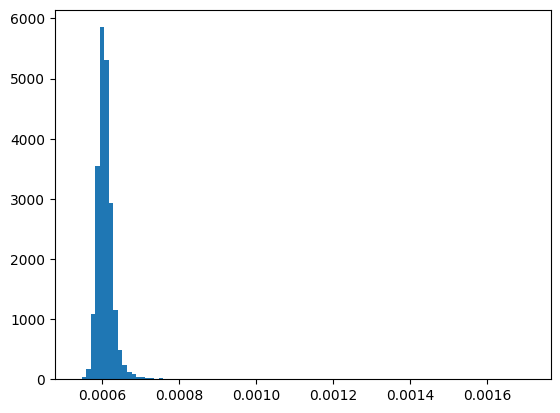

In [18]:
time_per_loop_np = np.array(time_per_loop_list)
plt.hist(time_per_loop_np, bins=100)
plt.show()